# Tesla Deliveries (2015–2025)
## Market Maturity (CAGR) & Hierarchical Clustering (Ward)

**Final clean version (Colab-ready)**

- Period: **2018–2024**
- Features: **CAGR**, **AvgDeliveries**, **StdDeliveries**
- Method: **Hierarchical Clustering (Ward)**
- Final segmentation: **k = 3**
- Visuals:
  - Dendrogram with cut
  - Scatterplot with relevant lifecycle boundaries

⚠️ Note: All displayed tables use **index starting from 1** (display-only, data unaffected).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.pyplot as plt

In [ ]:
# === Load data (upload CSV in Colab session) ===
df = pd.read_csv("tesla_deliveries_dataset_2015_2025.csv")

df_display = df.copy()
df_display.index += 1
df_display.head()

,Year,Month,Region,Model,Estimated_Deliveries,Production_Units,Avg_Price_USD,Battery_Capacity_kWh,Range_km,CO2_Saved_tons,Source_Type,Charging_Stations
1,2023,5,Europe,Model S,17646,17922,92874.27,120,704,1863.42,Interpolated (Month),12207
2,2015,2,Asia,Model X,3797,4164,62205.65,75,438,249.46,Official (Quarter),7640
3,2019,1,North America,Model X,8411,9189,117887.32,82,480,605.59,Interpolated (Month),14071
4,2021,2,North America,Model 3,6555,7311,89294.91,120,712,700.07,Official (Quarter),9333
5,2016,12,Middle East,Model Y,12374,13537,114846.78,120,661,1226.88,Estimated (Region),8722


In [ ]:
# Standardize column names
df = df.rename(columns={"Estimated_Deliveries": "Deliveries"})

required = ["Year", "Region", "Model", "Deliveries"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [ ]:
# Filter analysis period
START_YEAR, END_YEAR = 2018, 2024
df_period = df[df["Year"].between(START_YEAR, END_YEAR)].copy()

df_period_display = df_period.copy()
df_period_display.index += 1
df_period_display.head()

,Year,Month,Region,Model,Deliveries,Production_Units,Avg_Price_USD,Battery_Capacity_kWh,Range_km,CO2_Saved_tons,Source_Type,Charging_Stations
1,2023,5,Europe,Model S,17646,17922,92874.27,120,704,1863.42,Interpolated (Month),12207
3,2019,1,North America,Model X,8411,9189,117887.32,82,480,605.59,Interpolated (Month),14071
4,2021,2,North America,Model 3,6555,7311,89294.91,120,712,700.07,Official (Quarter),9333
6,2020,4,Asia,Model X,4656,5043,86930.57,82,477,333.14,Official (Quarter),5798
8,2020,6,Europe,Cybertruck,8410,9192,73815.61,100,592,746.81,Official (Quarter),8216


## Step 1 — Annual aggregation (Year × Model × Region)

In [ ]:
df_annual = (
    df_period
    .groupby(["Year", "Model", "Region"], as_index=False)["Deliveries"]
    .sum()
)

df_annual_display = df_annual.copy()
df_annual_display.index += 1
df_annual_display.head()

,Year,Model,Region,Deliveries
1,2018,Cybertruck,Asia,99335
2,2018,Cybertruck,Europe,107876
3,2018,Cybertruck,Middle East,116634
4,2018,Cybertruck,North America,102410
5,2018,Model 3,Asia,134161


## Step 2 — Feature engineering (per Model × Region)

In [ ]:
rows = []

for (model, region), g in df_annual.groupby(["Model", "Region"]):
    g = g.sort_values("Year")
    years = g["Year"].to_numpy()
    vals = g["Deliveries"].to_numpy()

    if len(vals) < 2:
        continue

    first, last = float(vals[0]), float(vals[-1])
    n_years = int(years[-1] - years[0])

    if n_years <= 0 or first <= 0:
        continue

    cagr = (last / first) ** (1 / n_years) - 1
    std = float(np.std(vals, ddof=1))

    rows.append({
        "Model": model,
        "Region": region,
        "CAGR": cagr,
        "AvgDeliveries": np.mean(vals),
        "StdDeliveries": std
    })

feat = pd.DataFrame(rows)

feat_display = feat.copy()
feat_display.index += 1
feat_display.head()

,Model,Region,CAGR,AvgDeliveries,StdDeliveries
1,Cybertruck,Asia,0.048925,111873.285714,13682.159292
2,Cybertruck,Europe,0.013320,112203.000000,8478.073445
3,Cybertruck,Middle East,0.018522,124869.571429,13715.837170
4,Cybertruck,North America,0.045164,113935.000000,11909.709232
5,Model 3,Asia,-0.035473,118762.571429,9842.368750


## Step 3 — Hierarchical clustering (Ward), k = 3

In [ ]:
features = ["CAGR", "AvgDeliveries", "StdDeliveries"]
X = feat[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Z = linkage(X_scaled, method="ward")

K_FINAL = 3
feat["Cluster"] = fcluster(Z, t=K_FINAL, criterion="maxclust")

feat_clustered_display = feat.copy()
feat_clustered_display.index += 1
feat_clustered_display.head()

,Model,Region,CAGR,AvgDeliveries,StdDeliveries,Cluster
1,Cybertruck,Asia,0.048925,111873.285714,13682.159292,1
2,Cybertruck,Europe,0.013320,112203.000000,8478.073445,1
3,Cybertruck,Middle East,0.018522,124869.571429,13715.837170,3
4,Cybertruck,North America,0.045164,113935.000000,11909.709232,1
5,Model 3,Asia,-0.035473,118762.571429,9842.368750,2


## Dendrogram with cut

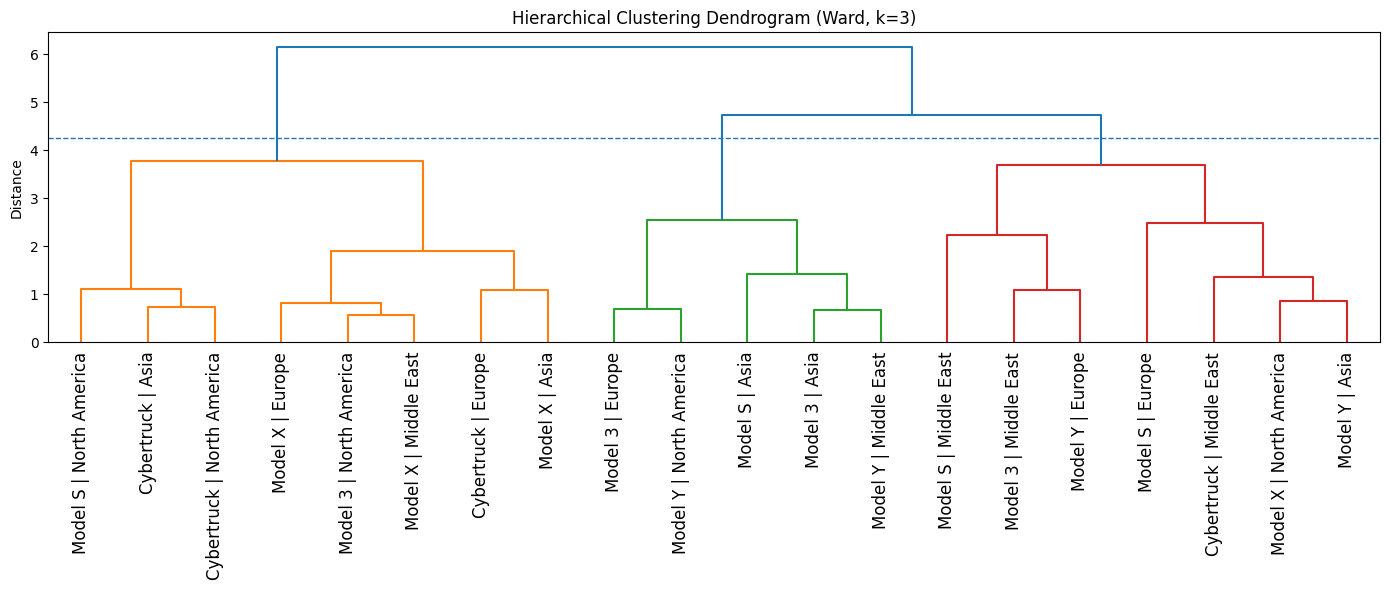

In [ ]:
def find_cut_distance(Z, k):
    d = np.sort(np.unique(Z[:, 2]))
    for i in range(len(d) - 1):
        t = (d[i] + d[i+1]) / 2
        if len(np.unique(fcluster(Z, t=t, criterion="distance"))) == k:
            return t
    return d[-1]

CUT_DISTANCE = find_cut_distance(Z, K_FINAL)

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=(feat["Model"] + " | " + feat["Region"]).to_list(),
    leaf_rotation=90,
    color_threshold=CUT_DISTANCE
)

plt.axhline(CUT_DISTANCE, linestyle="--", linewidth=1)
plt.title("Hierarchical Clustering Dendrogram (Ward, k=3)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

## Cluster summary

In [ ]:
cluster_summary = (
    feat.groupby("Cluster")[["CAGR", "AvgDeliveries", "StdDeliveries"]]
        .mean()
        .round(3)
)

cluster_summary.index = np.arange(1, len(cluster_summary) + 1)
cluster_summary

,CAGR,AvgDeliveries,StdDeliveries
1,0.015,114140.768,10410.082
2,-0.040,119939.143,13053.281
3,0.012,124010.755,12745.134


## Scatterplot — Market size vs growth (cleaned)

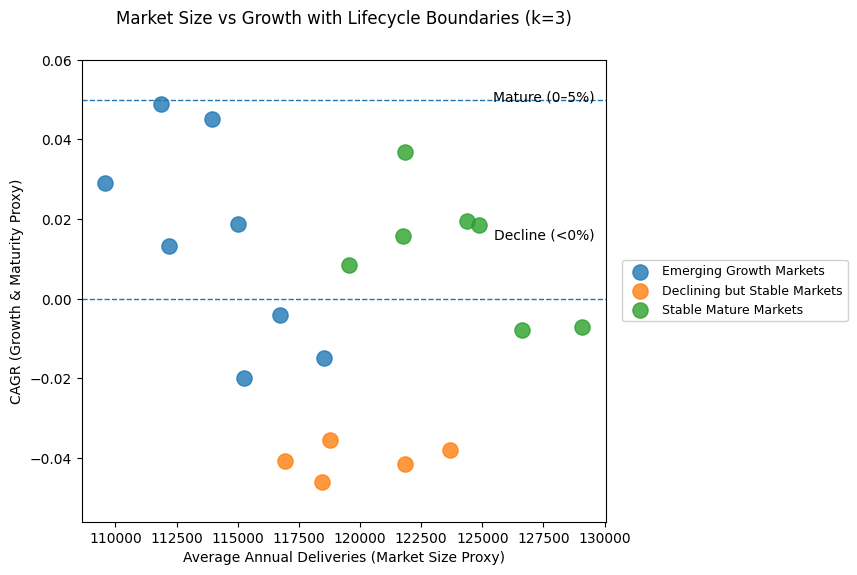

In [ ]:
# Scatterplot — Market size vs growth (cleaned, named clusters, legend not covering points)

# Build descriptive names for clusters based on their profiles (data-driven naming)
profile = feat.groupby("Cluster")[["CAGR", "AvgDeliveries", "StdDeliveries"]].mean()

growth_cluster = int(profile["CAGR"].idxmax())
decline_cluster = int(profile["CAGR"].idxmin())
remaining = [c for c in profile.index if c not in [growth_cluster, decline_cluster]]
mature_cluster = int(remaining[0]) if remaining else growth_cluster

max_std_cluster = int(profile["StdDeliveries"].idxmax())
mature_label = "Large but Volatile Mature Markets" if mature_cluster == max_std_cluster else "Stable Mature Markets"

name_map = {
    growth_cluster: "Emerging Growth Markets",
    decline_cluster: "Declining but Stable Markets",
    mature_cluster: mature_label,
}

fig, ax = plt.subplots(figsize=(8, 6))

for c in sorted(feat["Cluster"].unique()):
    sub = feat[feat["Cluster"] == c]
    ax.scatter(
        sub["AvgDeliveries"],
        sub["CAGR"],
        label=name_map.get(int(c), f"Cluster {c}"),
        s=120,
        alpha=0.8
    )

# Lifecycle boundary lines (relevant to observed range)
for t in [0.00, 0.05]:
    ax.axhline(t, linestyle="--", linewidth=1)

# Add a bit of headroom so labels never clash with the title
y_min = float(feat["CAGR"].min()) - 0.01
y_max = max(float(feat["CAGR"].max()) + 0.01, 0.06)
ax.set_ylim(y_min, y_max)

# Place labels in axes coordinates (stable placement)
ax.text(0.98, 0.92, "Mature (0–5%)", transform=ax.transAxes, ha="right", va="center")
ax.text(0.98, 0.62, "Decline (<0%)", transform=ax.transAxes, ha="right", va="center")

ax.set_xlabel("Average Annual Deliveries (Market Size Proxy)")
ax.set_ylabel("CAGR (Growth & Maturity Proxy)")

# More top padding because legend will sit above the axes
ax.set_title("Market Size vs Growth with Lifecycle Boundaries (k=3)", pad=26)

# Legend completely outside (right side)
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    framealpha=0.9,
    fontsize=9,
    title_fontsize=10
)

# Make room for the legend
fig.subplots_adjust(right=0.78)
plt.show()






In [ ]:
# Optional export
feat.to_csv("tesla_clusters_k3.csv", index=False)
cluster_summary.to_csv("tesla_cluster_summary_k3.csv", index=True)
print("Exports completed.")

Exports completed.
